In [1]:
from IslandTime import retrieve_island_info, Segmentation, update_results_map, plot_shoreline_transects, Workflow, update_data_map, TimeSeriesCoastSat, PreTimeSeries, TimeSeriesERA5, TimeSeriesClimateIndices
import pandas as pd
import os
from tqdm import tqdm
import shapely
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy import stats
import inspect
import numpy as np
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2


Successfully saved authorization token.


In [ ]:
path_to_fig = os.path.join(os.getcwd(), 'figures', 'seasonality_BEAST')
list_files = os.listdir(path_to_fig)

for file in list_files:
    t = os.path.getmtime(os.path.join(path_to_fig, file))
    # into datetime
    t = pd.to_datetime(t, unit='s')
    # print(t)
    if t < pd.to_datetime('2024-07-16'):
        print(file)


In [29]:
gdf = gpd.read_file('shp//Huvadhoo_included.shp')
gdf

,FID,geometry
0,0,"MULTIPOINT ((73.08961 0.26550), (73.51679 5.24..."


In [23]:
gdf = gpd.read_file('shp//islands_with_seasonality_cond3.shp')
# gdf = gpd.read_file('shp//Huvadhoo_included.shp')
# get number of points in MultiPoint
ii = []
for i in gdf['geometry'][0].geoms:
    ii.append(i)

print(len(ii))

# for i in gdf['geometry'][0].geoms:
#     print(i)

155


In [ ]:
gdf = gpd.read_file('shp//islands_seasonality_results.shp')

In [41]:
def asymmetric_seasonal_function_fitting(x, A, k, T1, T2, phi, offset):
    period = T1 + T2
    x_mod = (x + phi) % period
    if x_mod < T1:
        return A * np.exp(k * x) * np.sin(2 * np.pi * x_mod / T1) + offset
    else:
        return A * np.exp(k * x) * np.sin(2 * np.pi * (x_mod - T1) / T2) + offset

def asymmetric_seasonal_function_fitting_wrapper(x, A, k, T1, T2, phi, offset):
    return np.array([asymmetric_seasonal_function_fitting(xi, A, k, T1, T2, phi, offset) for xi in x])

def seasonal_function_fitting(x, A, k, period, phi, offset):
    return A * np.exp(k * x) * np.sin(2 * np.pi / period * x + phi) + offset

initial_guess = [7, 0.001, 182, 182, 90, 0] 
initial_guess2 = [7, 0.001, 365, 90, 0]

numeric_dates = np.array([(date - ts.index[0]).days for date in ts.index])
numeric_dates_big = np.linspace(0, numeric_dates[-1], 1000)
# dates_big = np.array([ts.index[0] + pd.Timedelta(days=xi) for xi in numeric_dates_big])

params, _ = curve_fit(asymmetric_seasonal_function_fitting_wrapper, xdata=numeric_dates, ydata=res_B.season.Y, p0=initial_guess)
params2, _ = curve_fit(seasonal_function_fitting, xdata=numeric_dates, ydata=res_B.season.Y, p0=initial_guess2)

# plot
plt.plot(ts.index, res_B.season.Y, label='data')
plt.plot(ts.index, asymmetric_seasonal_function_fitting_wrapper(numeric_dates, *params), label='fit')
plt.plot(ts.index, seasonal_function_fitting(numeric_dates, *params2), label='fit2')

# print r2

r2 = 1 - np.sum((res_B.season.Y - asymmetric_seasonal_function_fitting_wrapper(numeric_dates, *params))**2) / np.sum((res_B.season.Y - np.mean(res_B.season.Y))**2)
r2_2 = 1 - np.sum((res_B.season.Y - seasonal_function_fitting(numeric_dates, *params2))**2) / np.sum((res_B.season.Y - np.mean(res_B.season.Y))**2)
print(r2, r2_2)

0.9983079344012772 0.997070302530704


In [25]:
ts_name = 'coastline_position_transect_10_waterline'
ts = island_info['timeseries_preprocessing']['optimal time period']['dict_timeseries'][ts_name]['monthly'][ts_name] 
p = island_info['timeseries_analysis'][ts_name]['seasonality']['peaks_seasonal_BEAST']
stats.mode([ts.index[p][i].month for i in range(len(p))]).mode

3

In [141]:
import numpy as np
from celluloid import Camera

fig, ax = plt.subplots(figsize=(10, 10))

# Polygon of the reference shoreline
reference_shoreline = island_info['spatial_reference']['reference_shoreline']
polygon_reference_shoreline = shapely.geometry.Polygon(reference_shoreline)
transects_geo = island_info['spatial_reference']['transects']

# Short cut for time series analysis results
ts_analysis_results = island_info['timeseries_analysis']
ts_pp = island_info['timeseries_preprocessing']

# Get transect keys 
key_transects = [int((key).split('_')[3]) for key in ts_analysis_results.keys()]

ax.plot(reference_shoreline[:, 0], reference_shoreline[:, 1], 'k-', zorder=1)
ax.axis('off')
# ax.set_xlabel('Longitude', fontsize=15)
# ax.set_ylabel('Latitude', fontsize=15)

# Get intersections between transects and reference shoreline
intersections = [polygon_reference_shoreline.exterior.intersection(shapely.geometry.LineString(transects_geo[key_transect])) for key_transect in key_transects]

# x and y coordinates of intersections
x_intersections = []
y_intersections = []
for intersection in intersections:
    if type(intersection) == shapely.geometry.MultiPoint:
        # Take the first point of the MultiPoint
        x_intersections.append(intersection.geoms[0].x)
        y_intersections.append(intersection.geoms[0].y)
    
    elif type(intersection) == shapely.geometry.LineString:
        x_intersections.append(None)
        y_intersections.append(None)
    else:
        x_intersections.append(intersection.x)
        y_intersections.append(intersection.y)

cc = []
for val in ts_analysis_results.keys():
    ts = ts_pp['optimal time period']['dict_timeseries'][val]['monthly'][val]
    p = ts_analysis_results[val]['seasonality']['peaks_seasonal_BEAST']
    if sum(ts_analysis_results[val]['seasonality']['conditions_seasonality'].values()) >= 1:
        dates_p = ts.index[p]
        mode_dates_p = stats.mode([dates_p[i].month for i in range(len(p))]).mode
        cc.append(mode_dates_p)
    
    else:
        cc.append(None)

spa = ax.scatter(x_intersections, y_intersections, s=100, c=cc, cmap='Paired', edgecolor='k')
cbar = fig.colorbar(spa, ax=ax)

fig_a, ax_a = plt.subplots(figsize=(20, 10))
camera = Camera(fig_a)
ax_a.plot(reference_shoreline[:, 0], reference_shoreline[:, 1], 'k-', zorder=1)
ax_a.axis('off')

# dict month to month full name
month_dict = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}

for month in range(1, 13):

    ax_a.plot(reference_shoreline[:, 0], reference_shoreline[:, 1], 'k-', zorder=1)
    ax_a.axis('off')

    # Get the center of the image
    centre_image = np.array([np.mean(reference_shoreline[:, 0]), np.mean(reference_shoreline[:, 1])])

    ax_a.text(centre_image[0], centre_image[1], month_dict[month], fontsize=25, color='black', ha='center', va='center')
    # Starting point (xytext)
    for x, y, m, kt in zip(x_intersections, y_intersections, cc, key_transects):
        if m == month:
            end_point = np.array([transects_geo[kt][1, :][0], transects_geo[kt][1, :][1]])

            # Original endpoint (xy)
            start_point = np.array([x, y])

            # Calculate the direction vector
            direction_vector = end_point - start_point

            # Scale the direction vector to get a shorter vector
            scale_factor = 0.3  # Adjust this factor to control the length of the new vector
            shorter_direction_vector = direction_vector * scale_factor

            # Calculate the new endpoint
            new_end_point = start_point + shorter_direction_vector

            # Annotate with the shorter vector
            ax_a.annotate('', xytext=(new_end_point[0], new_end_point[1]), xy=(start_point[0], start_point[1]),
                        arrowprops=dict(arrowstyle='<-', color='black'))
            
    camera.snap()

animation = camera.animate()
animation.save('{}.gif'.format('seasons_test'), writer='Pillow', fps=0.5)

MovieWriter Pillow unavailable; using Pillow instead.


# Gradients

In [107]:
s_transects = [10, 3, 73, 65, 59, 54, 46, 36, 27, 17]
# Short cut for time series analysis results
ts_analysis_results = island_info['timeseries_analysis']
ts_pp = island_info['timeseries_preprocessing']

val = 'coastline_position_transect_{}_waterline'.format(s_transects[0])

# for val in ts_analysis_results.keys():
ts = ts_pp['optimal time period']['dict_timeseries'][val]['monthly'][val]
p = ts_analysis_results[val]['seasonality']['peaks_seasonal_BEAST']

In [132]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

val = 'coastline_position_transect_{}_waterline'.format(s_transects[0])
plt.plot(NormalizeData(ts_analysis_results[val]['seasonality']['seasonal_fit_BEAST']))
# val = 'coastline_position_transect_{}_waterline'.format(s_transects[1])
# plt.plot(NormalizeData(ts_analysis_results[val]['seasonality']['seasonal_fit_BEAST']))
# val = 'coastline_position_transect_{}_waterline'.format(s_transects[-1])
# plt.plot(NormalizeData(ts_analysis_results[val]['seasonality']['seasonal_fit_BEAST']))
val = 'coastline_position_transect_{}_waterline'.format(s_transects[-2])
plt.plot(NormalizeData(ts_analysis_results[val]['seasonality']['seasonal_fit_BEAST']))

In [154]:
def sediment_transport_direction(time_series1, time_series2):
    # Compute the cross-correlation
    correlation = signal.correlate(time_series2, time_series1, mode='full')
    lags = signal.correlation_lags(len(time_series2), len(time_series1), mode='full')
    lag = lags[np.argmax(correlation)]

    return np.sign(lag)

val = 'coastline_position_transect_{}_waterline'.format(27)
signal1 = NormalizeData(ts_analysis_results[val]['seasonality']['seasonal_fit_BEAST'])

plt.plot(signal1, label=val)

val = 'coastline_position_transect_{}_waterline'.format(10)
signal2 = NormalizeData(ts_analysis_results[val]['seasonality']['seasonal_fit_BEAST'])


plt.plot(signal2, label=val)

plt.legend()

sediment_transport_direction(signal1, signal2)

1

In [128]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

# Example signals
# Create two example signals with a delay
val = 'coastline_position_transect_{}_waterline'.format(s_transects[0])
signal1 = NormalizeData(ts_analysis_results[val]['seasonality']['seasonal_fit_BEAST'])

val = 'coastline_position_transect_{}_waterline'.format(s_transects[-2])
signal2 = NormalizeData(ts_analysis_results[val]['seasonality']['seasonal_fit_BEAST'])

t = np.arange(len(signal1))

# Compute the cross-correlation
correlation = signal.correlate(signal2, signal1, mode='full')
lags = signal.correlation_lags(len(signal2), len(signal1), mode='full')
lag = lags[np.argmax(correlation)]

# Determine the direction of propagation
if lag > 0:
    direction = "right to left"
elif lag < 0:
    direction = "left to right"
else:
    direction = "no delay"

print(f"Direction of propagation: {direction}")

# Plot the signals and the cross-correlation
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(t, signal1, label='Signal 1')
plt.plot(t, signal2, label='Signal 2')
plt.legend()
plt.title("Signals")

plt.subplot(3, 1, 2)
plt.plot(lags / fs, correlation)
plt.title("Cross-correlation")
plt.xlabel("Time lag (s)")
plt.ylabel("Correlation")

plt.subplot(3, 1, 3)
plt.plot(t, signal1, label='Signal 1')
plt.plot(t, np.roll(signal2, -lag), label='Aligned Signal 2')
plt.legend()
plt.title("Aligned Signals")

plt.tight_layout()
plt.show()

Direction of propagation: left to right


In [123]:
fig, ax = plt.subplots(figsize=(10, 10))

# Polygon of the reference shoreline
reference_shoreline = island_info['spatial_reference']['reference_shoreline']
polygon_reference_shoreline = shapely.geometry.Polygon(reference_shoreline)
transects_geo = island_info['spatial_reference']['transects']

# Short cut for time series analysis results
ts_analysis_results = island_info['timeseries_analysis']
ts_pp = island_info['timeseries_preprocessing']

# Get transect keys 
key_transects = s_transects

ax.plot(reference_shoreline[:, 0], reference_shoreline[:, 1], 'k-', zorder=1)
ax.axis('off')
# ax.set_xlabel('Longitude', fontsize=15)
# ax.set_ylabel('Latitude', fontsize=15)

# Get intersections between transects and reference shoreline
intersections = [polygon_reference_shoreline.exterior.intersection(shapely.geometry.LineString(transects_geo[key_transect])) for key_transect in key_transects]

# x and y coordinates of intersections
x_intersections = []
y_intersections = []
for intersection in intersections:
    if type(intersection) == shapely.geometry.MultiPoint:
        # Take the first point of the MultiPoint
        x_intersections.append(intersection.geoms[0].x)
        y_intersections.append(intersection.geoms[0].y)
    
    elif type(intersection) == shapely.geometry.LineString:
        x_intersections.append(None)
        y_intersections.append(None)
    else:
        x_intersections.append(intersection.x)
        y_intersections.append(intersection.y)

cc = []
for s in s_transects:
    val = 'coastline_position_transect_{}_waterline'.format(s)
    ts = ts_pp['optimal time period']['dict_timeseries'][val]['monthly'][val]
    p = ts_analysis_results[val]['seasonality']['peaks_seasonal_BEAST']
    if sum(ts_analysis_results[val]['seasonality']['conditions_seasonality'].values()) >= 1:
        dates_p = ts.index[p]
        mode_dates_p = stats.mode([dates_p[i].month for i in range(len(p))]).mode
        cc.append(mode_dates_p)
    
    else:
        cc.append(None)

spa = ax.scatter(x_intersections, y_intersections, s=100, c=cc, cmap='Paired', edgecolor='k')
cbar = fig.colorbar(spa, ax=ax)

In [4]:
def delta_method(COVB, param, x_new, f, x, y, alpha):
    # - - -
    # Function to calculate the confidence interval and prediction interval
    # for any user-defined regression function using the delta-method
    # as described in Sec 5.1 of the following online statistics lecture:
    # https://jchiquet.github.io/MAP566/docs/regression/map566-lecture-nonlinear-regression.html
    #
    # Greg Pelletier (gjpelletier@gmail.com)
    # - - -
    # INPUT
    # COVB = variance-covariance matrix of the model parameters (e.g. from scipy or lmfit)
    # param = best-fit parameters of the regression function (e.g. from scipy or lmfit)
    # x_new = new x values to evaluate new predicted y_new values (e.g. x_new=linspace(min(x),max(x),100)
    # f = user-defined regression lambda function to predict y given inputs if param and x values (e.g. observed x or x_new)
    # 	For example, if using the 3-parameter nonlinear regression exponential threshold function, then
    # 	f = lambda param,xval : param[0] + param[1] * exp(param[2] * xval)
    # x = observed x
    # y = observed y
    # alpha = significance level for the confidence/prediction interval (e.g. alpha=0.05 is the 95% confidence/prediction interval)
    # - - -
    # OUTPUT
    # dict = dictionary of output varlables with the following keys:
    #        'param': best-fit parameter values used as input
    #        'COVB': variance-covariance matrix used as input
    #        'fstr': string of the input lambda function of the regression model
    #        'alpha': input significance level for the confidence/prediction interval (e.g. alpha=0.05 is the 95% confidence/prediction interval)
    #        'x': observed x values used as input
    #        'y': observed y values used as input
    #        'yhat': predicted y at observed x values
    #        'x_new': new x-values used as input to evaluate unew predicted y_new values
    #        'y_new': new predicted y_new values at new x_new values
    #        'lwr_conf': lower confidence interval for each value in x_new
    #        'upr_conf': upper confidence interval for each value in x_new
    #        'lwr_pred': lower prediction interval for each value in x_new
    #        'upr_pred': upper prediction interval for each value in x_new
    #        'grad_new': derivative gradients at x_new (change in f(x_new) per change in each param)
    #        'G_new': variance due to each paramter at x_new
    #        'GS_new': variance due to all parameters combined at x_new
    #        'SST': Sum of Squares Total
    #        'SSR': Sum of Squares Regression
    #        'SSE': Sum of Squares Error
    #        'MSR': Mean Square Regression
    #        'MSE': Mean Square Error of the residuals
    #        'syx': standard error of the estimate
    #        'nobs': number of observations
    #        'nparam': number of parameters
    #        'df': degrees of freedom = nobs-nparam
    #        'qt': 2-tailed t-statistic at alpha
    #        'Fstat': F-statistic = MSR/MSE
    #        'dfn': degrees of freedom for the numerator of the F-test = nparam-1
    #        'dfd': degrees of freedom for the denominator of the F-test = nobs-nparam
    #        'pvalue': signficance level of the regression from the probability of the F-test
    #        'rsquared': r-squared = SSR/SST
    #        'adj_rsquared': adjusted squared
    # - - -
    # calculate predicted y_new at each x_new
    y_new = f(param, x_new)
    # calculate derivative gradients at x_new (change in f(x_new) per change in each param)
    grad_new = np.empty(shape=(np.size(x_new), np.size(param)))
    h = 1e-8       # h= small change for each param to balance truncation error and rounding error of the gradient
    for i in range(np.size(param)):
        # make a copy of param
        param2 = np.copy(param)
        # gradient forward
        param2[i] = (1+h) * param[i]
        y_new2 = f(param2, x_new)
        dy = y_new2 - y_new
        dparam = param2[i] - param[i]
        grad_up = dy / dparam
        # gradient backward
        param2[i] = (1-h) * param[i]
        y_new2 = f(param2, x_new)
        dy = y_new2 - y_new
        dparam = param2[i] - param[i]
        grad_dn = dy / dparam
        # centered gradient is the average gradient forward and backward
        grad_new[:,i] = (grad_up + grad_dn) / 2
    # calculate variance in y_new due to each parameter and for all parameters combined
    G_new = np.matmul(grad_new, COVB) * grad_new         # variance in y_new due to each param at each x_new
    GS_new = np.sum(G_new, axis=1)                       # total variance from all param values at each x_new
    # - - -
    # # lwr_conf and upr_conf are confidence intervals of the best-fit curve
    nobs = np.size(x)
    nparam = np.size(param)
    df = nobs - nparam
    qt = stats.t.ppf(1-alpha/2, df)
    delta_f = np.sqrt(GS_new) * qt
    lwr_conf = y_new - delta_f
    upr_conf = y_new + delta_f
    # - - -
    # # lwr_pred and upr_pred are prediction intervals of new observations
    yhat = f(param,x)
    SSE = np.sum((y-yhat) ** 2)                 # sum of squares (residual error)
    MSE = SSE / df                              # mean square (residual error)
    syx = np.sqrt(MSE)                          # std error of the estimate
    delta_y = np.sqrt(GS_new + MSE) * qt
    lwr_pred = y_new - delta_y
    upr_pred = y_new + delta_y
    # - - -
    # optional additional outputs of regression statistics
    SST = np.sum(y **2) - np.sum(y) **2 / nobs  # sum of squares (total)
    SSR = SST - SSE                             # sum of squares (regression model)
    MSR = SSR / (np.size(param)-1)              # mean square (regression model)
    Fstat = MSR / MSE           # F statistic
    dfn = np.size(param) - 1    # df numerator = degrees of freedom for model = number of model parameters - 1
    dfd = df                    # df denomenator = degrees of freedom of the residual = df = nobs - nparam
    pvalue = 1-stats.f.cdf(Fstat, dfn, dfd)      # p-value of F test statistic
    rsquared = SSR / SST                                                        # ordinary rsquared
    adj_rsquared = 1-(1-rsquared)*(np.size(x)-1)/(np.size(x)-np.size(param)-1)  # adjusted rsquared
    # - - -
    # make a string of the lambda function f to save in the output dictionary
    fstr = str(inspect.getsourcelines(f)[0])
    # make the dictionary of output variables from the delta-method
    dict = {
            'param': param,
            'COVB': COVB,
            'fstr': fstr,
            'alpha': alpha,
            'x': x,
            'y': y,
            'yhat': yhat,
            'x_new': x_new,
            'y_new': y_new,
            'lwr_conf': lwr_conf,
            'upr_conf': upr_conf,
            'lwr_pred': lwr_pred,
            'upr_pred': upr_pred,
            'grad_new': grad_new,
            'G_new': G_new,
            'GS_new': GS_new,
            'SST': SST,
            'SSR': SSR,
            'SSE': SSE,
            'MSR': MSR,
            'MSE': MSE,
            'syx': syx,
            'nobs': nobs,
            'nparam': nparam,
            'df': df,
            'qt': qt,
            'Fstat': Fstat,
            'dfn': dfn,
            'dfd': dfd,
            'pvalue': pvalue,
            'rsquared': rsquared,
            'adj_rsquared': adj_rsquared
            }

    return dict

In [27]:
# island = "Vaadhoo (Gaafu Dhaalu)"
country = 'Maldives'

# Retrieve island info
island_info = retrieve_island_info(island, country, verbose=False)

# ii = TimeSeriesCoastSat(island, country, distance_between_transects=5, reference_shoreline_transects_only=True, overwrite=True, retrieve_reference_shoreline_manually=True).main()

# plot_shoreline_transects(island_info)

# ii = Workflow(island, country, run_all=False, execute_analysis=True, execute_preprocess=False, execute_segmentation=False, update_maps=False, small_island=False, overwrite_analysis=False).main()

# ii = Segmentation(island_info, list_sat=['S2'], find_polygons=True, save=False, plot_results=True, plot_all=True, time_series_only=True, animation_polygons=False).main()

all_dict = pd.read_pickle(os.path.join(os.getcwd(), 'data', 'coastsat_data', '{}_{}'.format(island, country), 'all_polygons_{}_{}.data'.format(island, country)))
best_dict = pd.read_pickle(os.path.join(os.getcwd(), 'data', 'coastsat_data', '{}_{}'.format(island, country), 'best_polygons_{}_{}.data'.format(island, country)))

In [35]:
key = list(best_dict.keys())[0]
dict_georef = all_dict[2]
dict_rgb_ts = all_dict[1]
dict_poly = all_dict[0]

aff_mat = np.array([[dict_georef[key][1], dict_georef[key][2], dict_georef[key][0]],
                    [dict_georef[key][4], dict_georef[key][5], dict_georef[key][3]],
                    [0, 0, 1]])

# Create affine transformation
import skimage.transform as transform
tform = transform.AffineTransform(aff_mat)

polygon = dict_poly[key]['polygon_NIR_otsu']
x_poly, y_poly  = polygon.exterior.coords.xy

# Transform polygon
tmp = np.column_stack((x_poly, y_poly))
points_converted = tform(tmp)
poly_image_crs = shapely.geometry.Polygon(points_converted)

In [50]:
compactness = (4 * np.pi * poly_image_crs.area) / (poly_image_crs.length ** 2)
convex_hull = poly_image_crs.convex_hull
solidity = poly_image_crs.area / convex_hull.area
bounding_box = poly_image_crs.bounds
min_rotated_rect = poly_image_crs.minimum_rotated_rectangle
mrr_coords = list(min_rotated_rect.exterior.coords)
major_axis = max([mrr_coords[i][0] - mrr_coords[i-1][0] for i in range(len(mrr_coords))])
minor_axis = max([mrr_coords[i][1] - mrr_coords[i-1][1] for i in range(len(mrr_coords))])
elongation = major_axis / minor_axis

def calculate_curvature(polygon):
    coords = np.array(polygon.exterior.coords)
    angles = []
    for i in range(len(coords) - 2):
        v1 = coords[i+1] - coords[i]
        v2 = coords[i+2] - coords[i+1]
        angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
        if not np.isnan(angle):
            angles.append(angle)
    return np.mean(angles)

avg_curvature = calculate_curvature(poly_image_crs)

In [51]:
compactness, solidity, elongation, avg_curvature

(0.5710523112999077,
 0.9516542785119299,
 1.2297719109852085,
 0.27854959513273636)

In [4]:
import numpy as np
import skimage.exposure as exposure
import pyproj

def _image_stretch(im):
    # Rescale image for visualisation
    if np.ndim(im) > 2:
        for i in range(np.shape(im)[2]):
            im_no_nan = im[:, :, i][~np.isnan(im[:, :, i])]
            im[:, :, i] = exposure.rescale_intensity(im[:, :, i], in_range=(im_no_nan.min(), im_no_nan.max()))
    
    else:
        im_no_nan = im[~np.isnan(im)]
        im = exposure.rescale_intensity(im, in_range=(im_no_nan.min(), im_no_nan.max()))
    
    return im

rgb = all_dict[1]['26-08-2015_S2']
georef = all_dict[2]['26-08-2015_S2']

fig, ax = plt.subplots()

ax.imshow(_image_stretch(rgb), extent=[georef[0], georef[0] + georef[1] * rgb.shape[1], georef[3] + georef[5] * rgb.shape[0], georef[3]])
plot_shoreline_transects(island_info, transect_plot=10, ax=ax)
ax.axis('off')

(280860.0, 281410.0, 583140.0, 583680.0)

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from matplotlib.collections import PolyCollection, LineCollection

t = 2
ts = island_info['timeseries_preprocessing']['optimal time period']['dict_timeseries']['coastline_position_transect_{}_waterline'.format(t)]['monthly']['coastline_position_transect_{}_waterline'.format(t)]

def plot_acf_colors(ax, markercolor="firebrick", linecolor="black", facecolor="silver", barcolor="darkcyan", linewidth=1):
    """utility function to get some control over colors with  plot_acf()"""
    
    for item in ax.collections:
        # change the color of the confidence interval 
        if type(item) == PolyCollection:
            item.set_facecolor(facecolor)
        # change the color of the vertical lines
        if type(item) == LineCollection:
            item.set_color(barcolor)
    # change the color of the markers
    [line.get_label() for line in ax.lines]
    for item in ax.lines:
        item.set_color(markercolor)
    # change the color of the horizontal lines
    ax.lines[0].set_color(linecolor)
    ax.lines[0].set_linewidth(linewidth)
    #ax.lines.remove(ax.lines[0])
    return ax

fig, axs = plt.subplots(2,2, figsize=(20,20))
axs = axs.ravel()
plot_acf(ts, lags=40, alpha=0.1, ax=axs[2], color='k', use_vlines=True, fft=True, vlines_kwargs={'colors': 'k', 'linestyles': 'dashed'}, title='', gapcolor='k')
ax = plot_acf_colors(axs[2])
axs[2].axvline(x=12, color='k', linestyle='-', linewidth=0.5, zorder=0, alpha=0.5)
axs[2].axvline(x=6, color='k', linestyle='-', linewidth=0.5, zorder=0, alpha=0.5)
# ax.axvline(x=24, color='red', linestyle='--')
# ax.axvline(x=36, color='red', linestyle='--')
# ax.axvline(x=6, color='g', linestyle='--', label='6 months')
# ax.axvline(x=18, color='g', linestyle='--')
# ax.axvline(x=30, color='g', linestyle='--')
axs[2].set_xlabel('Lag (months)', fontsize=20)
axs[2].set_ylabel('Autocorrelation', fontsize=20)
axs[2].text(12.5, 0.8, '12 months', fontsize=20, fontweight='bold')
axs[2].text(6.5, 0.8, '6 months', fontsize=20, fontweight='bold')
axs[2].set_xlim(-1, 40.5)
axs[2].set_ylim(-1.05, 1.05)

axs[1].plot(ts, color='k', linewidth=1.5, label='Preprocessed time series')
axs[1].set_xlabel('Time', fontsize=20)
axs[1].set_ylabel('Coastline position (m)', fontsize=20)
axs[1].legend()
# plot_shoreline_transects(island_info, ax=axs[0], transect_plot=10)

axs[3].plot(ts, color='k', linewidth=1.5, alpha=0.3)
axs[3].set_xlabel('Time', fontsize=15)
axs[3].set_ylabel('Coastline position (m)', fontsize=20)
# ax.set_title('')
# ax.legend(fontsize=15)

import numpy as np
import skimage.exposure as exposure
import pyproj

def _image_stretch(im):
    # Rescale image for visualisation
    if np.ndim(im) > 2:
        for i in range(np.shape(im)[2]):
            im_no_nan = im[:, :, i][~np.isnan(im[:, :, i])]
            im[:, :, i] = exposure.rescale_intensity(im[:, :, i], in_range=(im_no_nan.min(), im_no_nan.max()))
    
    else:
        im_no_nan = im[~np.isnan(im)]
        im = exposure.rescale_intensity(im, in_range=(im_no_nan.min(), im_no_nan.max()))
    
    return im

kk = 98
georef = all_dict[2][list(all_dict[2].keys())[kk]]
rgb = all_dict[1][list(all_dict[1].keys())[kk]]

axs[0].imshow(_image_stretch(rgb), extent=[georef[0], georef[0] + georef[1] * rgb.shape[1], georef[3] + georef[5] * rgb.shape[0], georef[3]])
plot_shoreline_transects(island_info, transect_plot=t, ax=axs[0])
axs[0].axis('off')

from scipy.fft import fft
from scipy.signal import find_peaks, argrelextrema
from scipy import stats


time_series = ts
# Fourier transform of time series
fft_result = fft(time_series.values)

# Get frequencies
frequencies = np.fft.fftfreq(len(time_series.values), d=1)#1/12)

# fft_result without frequency 0
fft_result_n = fft_result[1:]

# Remove frequencies with amplitude below a threshold
#print(all(element is False for element in (stats.zscore(np.abs(fft_result_n)) > self.z_score_seasonality)))
score_list = stats.zscore(np.abs(fft_result_n)) > 2
if all(not element for element in score_list):
    fft_result = fft_result
else:
    threshold = np.min(np.abs(fft_result_n[stats.zscore(np.abs(fft_result_n)) > 2]))
    fft_result[np.abs(fft_result) < threshold] = 0

# Inverse Fourier transform (filetered data)
filtered_data_fourier = np.fft.ifft(fft_result).real

# Find peaks
peaks_fourier, _ = find_peaks(filtered_data_fourier, height=0)

# Find period
period_fourier = stats.mode(np.diff(peaks_fourier)).mode

axs[3].plot(time_series.index, filtered_data_fourier, color='seagreen', linewidth=1.5, label='Fourier-filtered time series')
ii=0
for peak in peaks_fourier:
        if ii==0:
            axs[3].axvline(time_series.index[peak], color='firebrick', linestyle='--', linewidth=0.8, label='Signal peaks')
        else:
            axs[3].axvline(time_series.index[peak], color='firebrick', linestyle='--', linewidth=0.8)
        ii+=1

import datetime
axs[3].annotate('', xy=(datetime.datetime(2017, 5, 1), 136), xytext=(datetime.datetime(2018, 4, 1), 136), arrowprops=dict(arrowstyle='<->', color='black'))
plt.text(datetime.datetime(2017, 10, 15), 138, '12 months', horizontalalignment='center', verticalalignment='center', fontsize=20, fontweight='bold')
axs[3].legend(fontsize=20)
# ax[1, 1].set_title('Fourier reconstruction'

# fig.savefig('figures//seasonal_signal.png', dpi=300)

# axs[0].text()

In [49]:
from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks

fig, ax = plt.subplots()
plot_acf(ts, lags=99, alpha=0.05, ax=ax, color='k', use_vlines=True, fft=True, vlines_kwargs={'colors': 'k', 'linestyles': 'dashed'}, title='', gapcolor='k')
ax = plot_acf_colors(ax)

# Define lags and compute ACF
lags_acf = acf(ts, nlags=len(time_series)-1)
# lags_acf = acf(ts, nlags=48)

# Define range of lags
range_lags_acf = np.arange(0, len(lags_acf))

# Define sinusoidal function (for fitting)
def seasonal_function_fitting(x, A, k, period, phi, offset):
    return A * np.exp(k * x) * np.sin(2 * np.pi / period * x + phi) + offset

initial_guess = [1, 0, 12, 0, 0]
popt, pcov = curve_fit(seasonal_function_fitting, range_lags_acf, lags_acf, p0=initial_guess)

# model lambda function to use in delta_method for any param or xval
f = lambda param,x : param[0] * np.exp(param[1] * x) * np.sin(2 * np.pi / param[2] * x + param[3]) + param[4] 

x_new = np.linspace(min(range_lags_acf), max(range_lags_acf), 100)

# Calculate confidence intervals
d_ = delta_method(pcov,popt,x_new,f,range_lags_acf,lags_acf,0.05)

# extract the output values from the delta-method output dictionary
y_new_ = d_['y_new']
lwr_conf_ = d_['lwr_conf']
upr_conf_ = d_['upr_conf']
lwr_pred_ = d_['lwr_pred']
upr_pred_ = d_['upr_pred']
rsquared_ = d_['rsquared']
pvalue_ = d_['pvalue']
syx_ = d_['syx']

# make string values of fit stats and eqn for the plot labels
pstr_ = '%.2e' %pvalue_
rsqstr_ = '%.4f' %rsquared_
b1str_ = '%.3f' %popt[0]
b2str_ = '%.3e' %popt[1]
b3str_ = '%.3e' %popt[2]
syxstr_ = '%.5f' %syx_
eqnstr_ = 'y = ' + b1str_ + ' exp(-' + b2str_ + ' * x) + ' + b3str_


# plt.plot(x_new, y_new, '--k', label='best-fit (lmfit)',linewidth=4)    # lmfit solution of best fit
plt.plot(x_new, y_new_, '-', label='best-fit (scipy)')     # scipy solution of best fit
# 95% prediction limits
plt.fill_between(x_new, d_['lwr_pred'], d_['upr_pred'],color="#d3d3d3", label='95% PI (delta method)')
# 95% confidence limits
plt.fill_between(x_new, d_['lwr_conf'], d_['upr_conf'],color="#ABABAB", label='95% CI (delta method)')
plt.legend(loc='upper right')
plt.title('Delta-method using scipy for parameters and covariance')
plt.xlabel('x= xdata')
plt.ylabel('y= ydata')
print(eqnstr_)
print('r^2 = '+ rsqstr_ +', p = '+ pstr_)
print('standard error of the regression = '+ syxstr_)
# plt.ticklabel_format(style='plain', axis='y')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

peaks, _ = find_peaks(y_new_, height=0)
print(peaks[0])


y = 0.433 exp(--2.506e-02 * x) + 1.218e+01
r^2 = 0.6689, p = 1.11e-16
standard error of the regression = 0.09905
12


# New version

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from matplotlib.collections import PolyCollection, LineCollection
import Rbeast as rb

t = 69
ts = island_info['timeseries_preprocessing']['optimal time period']['dict_timeseries']['coastline_position_transect_{}_waterline'.format(t)]['monthly']['coastline_position_transect_{}_waterline'.format(t)]
o = rb.beast(ts.values, deltat = '1/12 year', period='1 year')

def plot_acf_colors(ax, markercolor="#d62828", linecolor="black", facecolor="silver", barcolor="#003049", linewidth=1):
    """utility function to get some control over colors with  plot_acf()"""
    
    for item in ax.collections:
        # change the color of the confidence interval 
        if type(item) == PolyCollection:
            item.set_facecolor(facecolor)
        # change the color of the vertical lines
        if type(item) == LineCollection:
            item.set_color(barcolor)
    # change the color of the markers
    [line.get_label() for line in ax.lines]
    for item in ax.lines:
        item.set_color(markercolor)
    # change the color of the horizontal lines
    ax.lines[0].set_color(linecolor)
    ax.lines[0].set_linewidth(linewidth)
    #ax.lines.remove(ax.lines[0])
    return ax

fig, axs = plt.subplots(2,2, figsize=(20,20))
axs = axs.ravel()
plot_acf(ts, lags=40, alpha=0.05, ax=axs[1], color='k', use_vlines=True, fft=True, vlines_kwargs={'colors': 'k', 'linestyles': 'dashed'}, title='', gapcolor='k')
ax = plot_acf_colors(axs[1])
# axs[1].axvline(x=12, color='k', linestyle='-', linewidth=0.5, zorder=0, alpha=0.5)
# axs[1].axvline(x=6, color='k', linestyle='-', linewidth=0.5, zorder=0, alpha=0.5)
# axs[1].axvline(x=18, color='k', linestyle='-', linewidth=0.5, zorder=0, alpha=0.5)
# ax.axvline(x=24, color='red', linestyle='--')
# ax.axvline(x=36, color='red', linestyle='--')
# ax.axvline(x=6, color='g', linestyle='--', label='6 months')
# ax.axvline(x=18, color='g', linestyle='--')
# ax.axvline(x=30, color='g', linestyle='--')
axs[1].set_xlabel('Lag (months)', fontsize=20)
axs[1].set_ylabel('Autocorrelation', fontsize=20)
# axs[1].text(12.2, 0.75, '12 months', fontsize=15, fontweight='bold')
# axs[1].text(6.2, 0.85, '6 months', fontsize=15, fontweight='bold')
# axs[1].text(18.2, 0.65, '18 months', fontsize=15, fontweight='bold')
axs[1].set_xlim(-1, 40.5)
axs[1].set_ylim(-1.05, 1.05)
# Increase tick size
# We change the fontsize of minor ticks label 
axs[1].tick_params(axis='both', which='major', labelsize=12)
axs[3].tick_params(axis='both', which='major', labelsize=12)
# axs[1].tick_params(axis='both', which='minor', labelsize=20)

# axs[1].plot(ts, color='k', linewidth=1.5, label='Preprocessed time series')
# axs[1].set_xlabel('Time', fontsize=20)
# axs[1].set_ylabel('Coastline position (m)', fontsize=20)
# axs[1].legend()
# plot_shoreline_transects(island_info, ax=axs[0], transect_plot=10)

axs[3].plot(ts, color='#456990', linewidth=1.5, alpha=0.7, label='Preprocessed time series')
axs[3].set_xlabel('Time', fontsize=20)
axs[3].set_ylabel('Coastline position (m)', fontsize=20)
# ax.set_title('')
# ax.legend(fontsize=15)

import numpy as np
import skimage.exposure as exposure
import pyproj

def _image_stretch(im):
    # Rescale image for visualisation
    if np.ndim(im) > 2:
        for i in range(np.shape(im)[2]):
            im_no_nan = im[:, :, i][~np.isnan(im[:, :, i])]
            im[:, :, i] = exposure.rescale_intensity(im[:, :, i], in_range=(im_no_nan.min(), im_no_nan.max()))
    
    else:
        im_no_nan = im[~np.isnan(im)]
        im = exposure.rescale_intensity(im, in_range=(im_no_nan.min(), im_no_nan.max()))
    
    return im

kk = 73
# georef = all_dict[2][list(all_dict[2].keys())[kk]]
# rgb = all_dict[1][list(all_dict[1].keys())[kk]]

# axs[0].imshow(_image_stretch(rgb), extent=[georef[0], georef[0] + georef[1] * rgb.shape[1], georef[3] + georef[5] * rgb.shape[0], georef[3]])
plot_shoreline_transects(island_info, transect_plot=t, ax=axs[0])
axs[0].axis('off')

from scipy.fft import fft
from scipy.signal import find_peaks, argrelextrema
from scipy import stats


time_series = ts
# Fourier transform of time series
fft_result = fft(time_series.values)

# Get frequencies
frequencies = np.fft.fftfreq(len(time_series.values), d=1)#1/12)

# Only take the positive half of the spectrum
positive_freq = frequencies[:len(frequencies)//2]
positive_magnitude = np.abs(fft_result[:len(fft_result)//2])

# Convert frequency to cycles per year
positive_freq_yearly = positive_freq * 12

axs[2].plot(positive_freq_yearly[1:], positive_magnitude[1:], color='#20a39e', linewidth=1.5, label='Fast Fourier Transform')
axs[2].set_xlabel('Frequency (cycles per year)', fontsize=20)
axs[2].set_ylabel('Amplitude', fontsize=20)
axs[2].axvline(x=1, color='k', linestyle='-', linewidth=0.5, zorder=0, alpha=0.5)
axs[2].axvline(x=2, color='k', linestyle='-', linewidth=0.5, zorder=0, alpha=0.5)
axs[2].axvline(x=3, color='k', linestyle='-', linewidth=0.5, zorder=0, alpha=0.5)
axs[2].tick_params(axis='both', which='major', labelsize=12)
# axs[2].set_ylim(0, 600)
axs[2].set_xlim(0.1, 5)

# fft_result without frequency 0
fft_result_n = fft_result[1:]

# Remove frequencies with amplitude below a threshold
#print(all(element is False for element in (stats.zscore(np.abs(fft_result_n)) > self.z_score_seasonality)))
score_list = stats.zscore(np.abs(fft_result_n)) > 2.
if all(not element for element in score_list):
    fft_result = fft_result
else:
    threshold = np.min(np.abs(fft_result_n[stats.zscore(np.abs(fft_result_n)) > 2.]))
    fft_result[np.abs(fft_result) < threshold] = 0

# Only take the positive half of the spectrum
positive_freq = frequencies[:len(frequencies)//2]
positive_magnitude = np.abs(fft_result[:len(fft_result)//2])

# Convert frequency to cycles per year
positive_freq_yearly = positive_freq * 12

axs[2].plot(positive_freq_yearly[1:], positive_magnitude[1:], color='#ffba49', linewidth=2, ls = '--', label='Filtered Fast Fourier Transform')
axs[2].legend(fontsize=15)

# Inverse Fourier transform (filetered data)
filtered_data_fourier = np.fft.ifft(fft_result).real

# Find peaks
peaks_fourier, _ = find_peaks(filtered_data_fourier, height=0)

# Find period
period_fourier = stats.mode(np.diff(peaks_fourier)).mode
print(period_fourier)

axs[3].plot(time_series.index, filtered_data_fourier, color='#540d6e', linewidth=1.5, label='Fourier-filtered time series')
ii=0
for peak in peaks_fourier:
        if ii==0:
            axs[3].axvline(time_series.index[peak], color='#EF767A', linestyle='--', linewidth=1.3)
        else:
            axs[3].axvline(time_series.index[peak], color='#EF767A', linestyle='--', linewidth=1.3)
        ii+=1

import datetime
# axs[3].annotate('', xy=(datetime.datetime(2017, 5, 1), 136), xytext=(datetime.datetime(2018, 4, 1), 136), arrowprops=dict(arrowstyle='<->', color='black'))
# plt.text(datetime.datetime(2017, 10, 15), 138, '12 months', horizontalalignment='center', verticalalignment='center', fontsize=20, fontweight='bold')

# axs[3].annotate('', xy=(datetime.datetime(2017, 7, 1), 115), xytext=(datetime.datetime(2018, 1, 15), 115), arrowprops=dict(arrowstyle='<->', color='black'))
# plt.text(datetime.datetime(2017, 10, 1), 117, '7 months', horizontalalignment='center', verticalalignment='center', fontsize=20, fontweight='bold')

# axs[3].annotate('', xy=(datetime.datetime(2017, 2, 1), 95), xytext=(datetime.datetime(2017, 7, 1), 95), arrowprops=dict(arrowstyle='<->', color='black'))
# plt.text(datetime.datetime(2017, 4, 1), 97, '5 months', horizontalalignment='center', verticalalignment='center', fontsize=20, fontweight='bold')

axs[3].legend(fontsize=15, loc='best')
# ax[1, 1].set_title('Fourier reconstruction'

# fig.savefig('figures//non_seasonal_signal_new.png', dpi=300)

# axs[0].text()


INFO: To supress printing the parameers in beast(),      set print.options = 0 
INFO: To supress printing the parameers in beast_irreg(),set print.options = 0 
INFO: To supress printing the parameers in beast123(),   set extra.printOptions = 0  
INFO: To supress warning messages in beast(),            set quiet = 1 
INFO: To supress warning messages in beast_irreg(),      set quiet = 1 
INFO: To supress warning messages in beast123(),         set extra.quiet = 1  

#--------------------------------------------------#
#       Brief summary of Input Data                #
#--------------------------------------------------#
Data Dimension: One signal of length 65
IsOrdered     : Yes, ordered in time
IsRegular     : Yes, evenly spaced at interval of  0.0833333 year = 1 months = 30.4167 days
HasSeasonCmpnt: True  | period = 1 year = 12 months = 365 days. The model 'Y=Trend+Season+Error' is fitted.
              : Num_of_DataPoints_per_Period = period/deltaTime = 1/0.0833333 = 12
HasOutlier

In [116]:
mstl = MSTL(time_series, periods=[6, 12]).fit()
# mstl = STL(time_series, period=12, seasonal=13).fit()
# mstl.plot()

reconstructed_series = mstl.trend + mstl.seasonal['seasonal_6'] + mstl.seasonal['seasonal_12']

plt.plot(time_series.index, time_series.values, color='k', linewidth=1.5, label='Original time series')
plt.plot(time_series.index, reconstructed_series, color='r', linewidth=1.5, label='Reconstructed time series')

print(r2_score(time_series.values, reconstructed_series))
rmse = np.sqrt(np.mean((time_series.values - reconstructed_series)**2))
print(rmse)

0.6153790253156762
3.433443601168519


In [72]:
from statsmodels.tsa.seasonal import STL, MSTL
import Rbeast as rb
from datetime import datetime, timedelta

res = STL(time_series, period=12, seasonal=13).fit()
res_B = rb.beast(ts.values, start=[ts.index[0].year, ts.index[0].month, ts.index[0].day], season='harmonic', deltat='1/12 year', period='1 year', quiet=True, print_progress=False)
# rb.plot(res_B)
# res.plot()



fig, axs = plt.subplots(3, 1, figsize=(20,20), sharex=True)

# plot time series and trends
axs[0].plot(ts.index, ts, color='k', linewidth=2, ls=':', label='Preprocessed time series')
axs[0].plot(ts.index, res.trend, color='#003F5C', label='STL (trend component)', linewidth=2)
axs[0].plot(ts.index, res_B.trend.Y, color='#BC5090', label='BEAST (trend component)', linewidth=2)
for ii, b in enumerate(res_B.trend.cp[:3]):

    if np.isnan(b):
        continue

    fractional_yeard = b
    # Separate the year and the fraction
    yeard = int(fractional_yeard)
    fractiond = fractional_yeard - yeard

    # Calculate the number of days in the given year
    days_in_year = (datetime(yeard + 1, 1, 1) - datetime(yeard, 1, 1)).days

    # Calculate the number of days corresponding to the fractional part
    daysd = round(fractiond * days_in_year)

    # Get the final date by adding the days to the start of the year
    dated = datetime(yeard, 1, 1) + timedelta(days=daysd)

    formatted_dated = dated.strftime('%Y-%m-%d')

    # datetime format
    d = datetime.strptime(formatted_dated, '%Y-%m-%d')
    
    if ii == 0:
        axs[0].axvline(d, color='#BC5090', linestyle='--', linewidth=2, label='BEAST (breakpoints)')
    else:
        axs[0].axvline(d, color='#BC5090', linestyle='--', linewidth=2)


axs[0].fill_between(ts.index, res_B.trend.CI[:, 0], res_B.trend.CI[:, 1], alpha=0.2, color='#BC5090')
axs[0].set_xlim(ts.index[0], ts.index[-1])
axs[0].text(datetime(2020, 3, 1), 97, 'pIOD', fontsize=25, fontweight='bold')
axs[0].text(datetime(2020, 3, 1), 97, 'pIOD', fontsize=25, fontweight='bold')
axs[0].legend(fontsize=15, loc='upper left')
axs[1].set_xlim(ts.index[0], ts.index[-1])
axs[2].set_xlim(ts.index[0], ts.index[-1])


axs[1].plot(ts.index, res.seasonal, color='#003F5C', label='STL (seasonal component)', linewidth=2)
axs[1].plot(ts.index, res_B.season.Y, color='#BC5090', label='BEAST (seasonal component)', linewidth=2)
axs[1].fill_between(ts.index, res_B.season.CI[:, 0], res_B.season.CI[:, 1], alpha=0.2, color='#BC5090')
# ax.fill_between(ts.index, res.seasonal - res.seasonal, res.seasonal + res.seasonal, color='seagreen', alpha=0.3)
axs[1].set_xlim(ts.index[0], ts.index[-1])
axs[1].legend(fontsize=15, loc='upper left')
axs[2].set_xlabel('Time', fontsize=20)
axs[1].tick_params(axis='both', which='major', labelsize=12)
axs[2].tick_params(axis='both', which='major', labelsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[1].set_ylabel('Amplitude (m)', fontsize=20)
axs[0].set_ylabel('Amplitude (m)', fontsize=20)
axs[2].set_ylabel('Amplitude (m)', fontsize=20)

# Plot residuals

# custom the stem lines
(markers, stemlines, baseline) = axs[2].stem(ts.index, res.resid, label='STL (residuals)')
plt.setp(stemlines, linestyle="-", color='#003F5C')
plt.setp(markers, color='#003F5C', marker='o', markersize=5)
plt.setp(baseline, color="black", linewidth=1)
(markers, stemlines, baseline) = axs[2].stem(ts.index, res_B.data - res_B.season.Y - res_B.trend.Y, label='BEAST (residuals)')
plt.setp(stemlines, linestyle="-", color='#BC5090')
plt.setp(markers, color='#BC5090', marker='v')
plt.setp(baseline, color="black", linewidth=1)

# axs[2].plot(ts.index, res_B.data - res_B.season.Y - res_B.trend.Y, color='#BC5090', label='BEAST (residuals)', linewidth=2)
axs[2].legend(fontsize=15, loc='upper left')

plt.savefig('figures//STL_BEAST_new.png', dpi=300)

# calculate r2 for STL and BEAST
from sklearn.metrics import r2_score

r2_stl = r2_score(res.seasonal, res_B.season.Y)

print(r2_stl)

rmse = np.sqrt(np.mean((res.seasonal - res_B.season.Y)**2))

print(rmse)

print(res_B.R2)


0.935378130989653
2.568261810609259
[0.8381969]


In [22]:
# find peaks in seasonal component
from scipy.signal import find_peaks

peaks_beast, _ = find_peaks(res_B.season.Y, height=0)
# find minima
minima_beast = argrelextrema(res_B.season.Y, np.less)

# plot
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(ts.index, res.seasonal, color='k', label='STL (seasonal component)', linewidth=2)
ax.plot(ts.index, res_B.season.Y, color='r', label='BEAST (seasonal component)', linewidth=2)
ax.fill_between(ts.index, res_B.season.CI[:, 0], res_B.season.CI[:, 1], alpha=0.2, color='r')
ax.scatter(ts.index[peaks_beast], res_B.season.Y[peaks_beast], color='r', marker='o', s=50, label='BEAST peaks')
ax.scatter(ts.index[minima_beast], res_B.season.Y[minima_beast], color='r', marker='v', s=50, label='BEAST minima')
ax.legend(fontsize=15)

In [44]:
np.sqrt(np.mean((res.seasonal - res_B.season.Y)**2))

2.956824626848461

In [40]:
plt.plot(abs(res.seasonal - res_B.season.Y))

In [142]:
falig, ax = plt.subplots()
# plt.imshow(im)
ax.plot(np.arange(10), np.sin(np.arange(10)))
ax.annotate('', xy=(0, 0), xytext=(5, 0.2),
             arrowprops=dict(arrowstyle='<->', color='black'))

Text(5, 0.2, '')

In [ ]:
# Read file for islands to ignore
import shapely.geometry

df_islands_ignore = pd.read_excel('islands_to_ignore.xlsx')
list_islands_ignore = df_islands_ignore['Island'].values

path_to_data = os.path.join(os.getcwd(), 'data', 'info_islands')

multi_point = []

for file in tqdm(os.listdir(path_to_data)):
    island = file.split('_')[1] 
    country = file.split('_')[2].split('.')[0]

    if island in list_islands_ignore:
        continue

    try:
        island_info = retrieve_island_info(island, country, verbose=False)
        lat, lon = island_info['spatial_reference']['latitude'], island_info['spatial_reference']['longitude']
        all_dict = pd.read_pickle(os.path.join(os.getcwd(), 'data', 'coastsat_data', '{}_{}'.format(island, country), 'all_polygons_{}_{}.data'.format(island, country)))
        best_dict = pd.read_pickle(os.path.join(os.getcwd(), 'data', 'coastsat_data', '{}_{}'.format(island, country), 'best_polygons_{}_{}.data'.format(island, country)))

        point = shapely.geometry.Point(lon, lat)

        key = list(best_dict.keys())[0]
        dict_georef = all_dict[2]
        dict_rgb_ts = all_dict[1]
        dict_poly = all_dict[0]

        aff_mat = np.array([[dict_georef[key][1], dict_georef[key][2], dict_georef[key][0]],
                            [dict_georef[key][4], dict_georef[key][5], dict_georef[key][3]],
                            [0, 0, 1]])

        # Create affine transformation
        import skimage.transform as transform
        tform = transform.AffineTransform(aff_mat)

        polygon = dict_poly[key]['polygon_NIR_otsu']
        x_poly, y_poly  = polygon.exterior.coords.xy

        # Transform polygon
        tmp = np.column_stack((x_poly, y_poly))
        points_converted = tform(tmp)
        poly_image_crs = shapely.geometry.Polygon(points_converted)

        # area
        area = poly_image_crs.area
        compactness = (4 * np.pi * poly_image_crs.area) / (poly_image_crs.length ** 2)
        convex_hull = poly_image_crs.convex_hull
        solidity = poly_image_crs.area / convex_hull.area
        bounding_box = poly_image_crs.bounds
        min_rotated_rect = poly_image_crs.minimum_rotated_rectangle
        mrr_coords = list(min_rotated_rect.exterior.coords)
        major_axis = max([mrr_coords[i][0] - mrr_coords[i-1][0] for i in range(len(mrr_coords))])
        minor_axis = max([mrr_coords[i][1] - mrr_coords[i-1][1] for i in range(len(mrr_coords))])
        elongation = major_axis / minor_axis

        def calculate_curvature(polygon):
            coords = np.array(polygon.exterior.coords)
            angles = []
            for i in range(len(coords) - 2):
                v1 = coords[i+1] - coords[i]
                v2 = coords[i+2] - coords[i+1]
                angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
                if not np.isnan(angle):
                    angles.append(angle)
            return np.mean(angles)

        avg_curvature = calculate_curvature(poly_image_crs)

        # save area, compactness, solidity, elongation, avg_curvature into point

        
    except:
        print('Error with island:', island)
        continue

mp = shapely.geometry.MultiPoint(multi_point)
gdf = gpd.GeoDataFrame(geometry=[mp], crs='EPSG:4326')
# gdf.to_file('shp//Huvadhoo_included.shp')

# Maps for islands with seasonality

In [22]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import shapely.geometry
import geopandas as gpd
from shapely.geometry import Polygon, Point
import skimage.transform as transform

# Read file for islands to ignore
df_islands_ignore = pd.read_excel('islands_to_ignore.xlsx')
list_islands_ignore = df_islands_ignore['Island'].values
islands_HA = pd.read_excel('Huvadhoo_islands.xlsx')

path_to_data = os.path.join(os.getcwd(), 'data', 'info_islands')

# List to store the data
data_list = []
data_list_ns = []

for file in tqdm(os.listdir(path_to_data)):
    island = file.split('_')[1] 
    country = file.split('_')[2].split('.')[0]

    if island in list_islands_ignore:
        continue

    if island not in islands_HA['island'].values:
        continue

    try:
        island_info = retrieve_island_info(island, country, verbose=False)
        lat, lon = island_info['spatial_reference']['latitude'], island_info['spatial_reference']['longitude']
        point = shapely.geometry.Point(lon, lat)
        if 'timeseries_analysis' not in island_info:
            continue
        ts_analysis_results = island_info['timeseries_analysis']

        if 'conditions_seasonality' in ts_analysis_results[list(ts_analysis_results.keys())[0]]['seasonality'].keys():
            cond = [sum(ts_analysis_results[val]['seasonality']['conditions_seasonality'].values()) >= 3 for val in ts_analysis_results.keys()]
            # print(island, sum(cond))
            if sum(cond) > 5:
                data_list.append(point)
            
            else:
                data_list_ns.append(point)

    except Exception as e:
        print(f'Error with island: {island} - {str(e)}')
        continue


mp = shapely.geometry.MultiPoint(data_list)
gdf = gpd.GeoDataFrame(geometry=[mp], crs='EPSG:4326')
mp_ns = shapely.geometry.MultiPoint(data_list_ns)
gdf_ns = gpd.GeoDataFrame(geometry=[mp_ns], crs='EPSG:4326')

# Create GeoDataFrame
# gdf = gpd.GeoDataFrame(data_list, crs='EPSG:4326')

# Save to shapefile
gdf.to_file('shp//islands_with_seasonality_cond3.shp')
gdf_ns.to_file('shp//islands_without_seasonality_cond3.shp')

 75%|███████▍  | 303/406 [01:28<00:14,  7.27it/s]

Error with island: Mathihuttaa - IllegalArgumentException: Points of LinearRing do not form a closed linestring


100%|██████████| 406/406 [01:48<00:00,  3.76it/s]


# List of islands inside Huvadhoo Atoll

In [15]:
# Read file for islands to ignore
import pyproj
import pandas as pd
import osmnx as ox
import shapely
import os
from tqdm import tqdm
from IslandTime import retrieve_island_info
import geopandas as gpd
df_islands_ignore = pd.read_excel('islands_to_ignore.xlsx')
list_islands_ignore = df_islands_ignore['Island'].values

path_to_data = os.path.join(os.getcwd(), 'data', 'info_islands')

huvadhu_atoll = ox.geocode_to_gdf('Huvadhu Atoll, Maldives')
huvadhu_atoll_box = [huvadhu_atoll.bbox_north.values[0], \
                huvadhu_atoll.bbox_west.values[0], \
                huvadhu_atoll.bbox_south.values[0], \
                huvadhu_atoll.bbox_east.values[0]]

# create polygon with the bounding box
huvadhu_atoll_polygon = shapely.geometry.Polygon([(huvadhu_atoll_box[1], huvadhu_atoll_box[0]), \
                                                (huvadhu_atoll_box[1], huvadhu_atoll_box[2]), \
                                                (huvadhu_atoll_box[3], huvadhu_atoll_box[2]), \
                                                (huvadhu_atoll_box[3], huvadhu_atoll_box[0])])


data_list = []
data_not = []

for file in tqdm(os.listdir(path_to_data)):
    island = file.split('_')[1] 
    country = file.split('_')[2].split('.')[0]

    # if island in list_islands_ignore:
    #     continue

    try:
        island_info = retrieve_island_info(island, country, verbose=False)
        lat, lon = island_info['spatial_reference']['latitude'], island_info['spatial_reference']['longitude']
        point = shapely.geometry.Point(lon, lat)
        if huvadhu_atoll_polygon.contains(point):
            data_list.append(
                {
                    'island': island,
                    'country': country,
                    'geometry': point
                }
            )
        
        else:
            data_not.append(
                {
                    'island': island,
                    'country': country,
                    'geometry': point
                }                
            )
    
    except Exception as e:
        print(f'Error with island: {island} - {str(e)}')
        continue

gdf = gpd.GeoDataFrame(data_list, crs='EPSG:4326')
gdf_not = gpd.GeoDataFrame(data_not, crs='EPSG:4326')

gdf.to_file('shp//Huvadhoo_islands.shp')
gdf_not.to_file('shp//not_Huvadhoo_islands.shp')

 34%|███▎      | 137/406 [00:30<00:32,  8.34it/s]

Error with island: Heenaamaagalaa - Ran out of input


 48%|████▊     | 193/406 [00:39<01:30,  2.36it/s]

Error with island: Kalherehaa - Ran out of input


100%|██████████| 406/406 [01:20<00:00,  5.06it/s]


In [20]:
df.to_excel('Huvadhoo_islands.xlsx')

# Maps for seasonality minima, peaks, and amplitudes

In [15]:
# Read file for islands to ignore
import pyproj
import pandas as pd
df_islands_ignore = pd.read_excel('islands_to_ignore.xlsx')
list_islands_ignore = df_islands_ignore['Island'].values
islands_HA = pd.read_excel('Huvadhoo_islands.xlsx')

path_to_data = os.path.join(os.getcwd(), 'data', 'info_islands')

data_list = []

for file in tqdm(os.listdir(path_to_data)):
    island = file.split('_')[1] 
    country = file.split('_')[2].split('.')[0]

    if island in list_islands_ignore:
        continue

    if not island in islands_HA['island'].values:
        continue

    try:
        island_info = retrieve_island_info(island, country, verbose=False)
    
        if 'timeseries_analysis' in island_info.keys():
            if island_info['timeseries_analysis'] != {}:

                lon, lat = island_info['spatial_reference']['longitude'], island_info['spatial_reference']['latitude']
                
                
                # Extract reference shoreline and transects
                reference_shoreline = island_info['spatial_reference']['reference_shoreline']
                transects = island_info['spatial_reference']['transects']

                # Create a polygon from the reference shoreline
                polygon_reference_shoreline = shapely.geometry.Polygon(reference_shoreline)

                # Short cut for the time series analysis results
                ts_analysis_results = island_info['timeseries_analysis']

                # Extract the key of the transects
                key_transects = [int((key).split('_')[3]) for key in ts_analysis_results.keys()]

                # Extract the intersection between the reference shoreline and the transects
                x_intersections, y_intersections = [], []
                try:
                    intersections = [polygon_reference_shoreline.exterior.intersection(shapely.geometry.LineString(transects[key_transect])) for key_transect in key_transects]
                except:
                    continue
                for intersection in intersections:
                    if type(intersection) == shapely.geometry.MultiPoint:
                        # Take the first point of the MultiPoint
                        x_intersections.append(intersection.geoms[0].x)
                        y_intersections.append(intersection.geoms[0].y)

                    elif type(intersection) == shapely.geometry.LineString:
                        x_intersections.append(0.)
                        y_intersections.append(0.)

                    else:
                        x_intersections.append(intersection.x)
                        y_intersections.append(intersection.y)

                # Reproject the coordinates to the Web Mercator projection
                # Source and target coordinate reference systems
                tgt_crs = pyproj.CRS('EPSG:4326')
                src_crs = pyproj.CRS('EPSG:3857')

                # Define transformer
                transformer = pyproj.Transformer.from_crs(src_crs, tgt_crs, always_xy=True)

                # # Transform latitude and longitude to x and y
                x_intersections, y_intersections = transformer.transform(x_intersections, y_intersections)

                # Transform reference shoreline to x and y
                x_reference_shoreline, y_reference_shoreline = transformer.transform(polygon_reference_shoreline.exterior.coords.xy[0], polygon_reference_shoreline.exterior.coords.xy[1])

                # Trend splot and results (colorbar = trend slope and symbol = trend result)
                c_trend = [ts_analysis_results[val]['trend']['trend_slope'] for val in ts_analysis_results.keys()]
                symbols_trend = [ts_analysis_results[val]['trend']['trend_result'] for val in ts_analysis_results.keys()]

                # Seasonality amplitude results (colorbar = seasonality amplitude)
                if 'amplitude_seasonal_BEAST_absrange' in ts_analysis_results[list(ts_analysis_results.keys())[0]]['seasonality'].keys():
                    c_seasonality_amplitude = [ts_analysis_results[val]['seasonality']['amplitude_seasonal_STL_absrange'] for val in ts_analysis_results.keys()]
                    c_seasonality_amplitude_BEAST = [ts_analysis_results[val]['seasonality']['amplitude_seasonal_BEAST_absrange'] for val in ts_analysis_results.keys()]

                else:
                    c_seasonality_amplitude = [0. for val in ts_analysis_results.keys()]

                # Seasonality peaks and minima results
                if 'conditions_seasonality' in ts_analysis_results[list(ts_analysis_results.keys())[0]]['seasonality'].keys():
                    c_seasonality_peaks = [ts_analysis_results[val]['seasonality']['seasonality_indian_monsoon_peaks'] if sum(ts_analysis_results[val]['seasonality']['conditions_seasonality'].values()) >= 3 else 'undetermined' for val in ts_analysis_results.keys()]
                    c_seasonality_minima = [ts_analysis_results[val]['seasonality']['seasonality_indian_monsoon_minima'] if sum(ts_analysis_results[val]['seasonality']['conditions_seasonality'].values()) >= 3 else 'undetermined' for val in ts_analysis_results.keys()]
                    c_seasonality_peaks_BEAST = [ts_analysis_results[val]['seasonality']['seasonality_indian_monsoon_peaks_BEAST'] if sum(ts_analysis_results[val]['seasonality']['conditions_seasonality'].values()) >= 3 else 'undetermined' for val in ts_analysis_results.keys()]
                    c_seasonality_minima_BEAST = [ts_analysis_results[val]['seasonality']['seasonality_indian_monsoon_minima_BEAST'] if sum(ts_analysis_results[val]['seasonality']['conditions_seasonality'].values()) >= 3 else 'undetermined' for val in ts_analysis_results.keys()]
                
                else:
                    continue
                    
                # Add data to list
                for x in range(len(x_intersections)):
                    data_list.append({
                        'island': island,
                        'country': country,
                        'geometry': shapely.geometry.Point(x_intersections[x], y_intersections[x]),
                        'aSTL': c_seasonality_amplitude[x],
                        'aBEAST': c_seasonality_amplitude_BEAST[x],
                        'pSTL': c_seasonality_peaks[x],
                        'mSTL': c_seasonality_minima[x],
                        'pBEAST': c_seasonality_peaks_BEAST[x],
                        'mBEAST': c_seasonality_minima_BEAST[x]
                    })

    except Exception as e:
        print(f'Error with island: {island} - {str(e)}')
        continue

gdf = gpd.GeoDataFrame(data_list, crs='EPSG:4326')
gdf.to_file('shp//islands_seasonality_cond3_results.shp')


 75%|███████▍  | 303/406 [01:37<00:12,  8.22it/s]

Error with island: Mathihuttaa - IllegalArgumentException: Points of LinearRing do not form a closed linestring


100%|██████████| 406/406 [01:56<00:00,  3.48it/s]


# Map of aggregated results

In [ ]:
# Read file for islands to ignore
import pyproj
df_islands_ignore = pd.read_excel('islands_to_ignore.xlsx')
list_islands_ignore = df_islands_ignore['Island'].values

path_to_data = os.path.join(os.getcwd(), 'data', 'info_islands')

data_list = []

for file in tqdm(os.listdir(path_to_data)[:2]):
    island = file.split('_')[1] 
    country = file.split('_')[2].split('.')[0]

    if island in list_islands_ignore:
        continue

    try:
        island_info = retrieve_island_info(island, country, verbose=False)
    
        if 'timeseries_analysis' in island_info.keys():
            if island_info['timeseries_analysis'] != {}:

                lon, lat = island_info['spatial_reference']['longitude'], island_info['spatial_reference']['latitude']
                
                
                # Extract reference shoreline and transects
                reference_shoreline = island_info['spatial_reference']['reference_shoreline']
                transects = island_info['spatial_reference']['transects']

                # Create a polygon from the reference shoreline
                polygon_reference_shoreline = shapely.geometry.Polygon(reference_shoreline)

                # Short cut for the time series analysis results
                ts_analysis_results = island_info['timeseries_analysis']
                ts_analysis_agg = island_info['timeseries_aggregate']

                # # Extract the key of the transects
                # key_transects = [int((key).split('_')[3]) for key in ts_analysis_results.keys()]

                # # Extract the intersection between the reference shoreline and the transects
                # x_intersections, y_intersections = [], []
                # try:
                #     intersections = [polygon_reference_shoreline.exterior.intersection(shapely.geometry.LineString(transects[key_transect])) for key_transect in key_transects]
                # except:
                #     continue
                # for intersection in intersections:
                #     if type(intersection) == shapely.geometry.MultiPoint:
                #         # Take the first point of the MultiPoint
                #         x_intersections.append(intersection.geoms[0].x)
                #         y_intersections.append(intersection.geoms[0].y)

                #     elif type(intersection) == shapely.geometry.LineString:
                #         x_intersections.append(0.)
                #         y_intersections.append(0.)

                #     else:
                #         x_intersections.append(intersection.x)
                #         y_intersections.append(intersection.y)

                # # Reproject the coordinates to the Web Mercator projection
                # # Source and target coordinate reference systems
                # tgt_crs = pyproj.CRS('EPSG:4326')
                # src_crs = pyproj.CRS('EPSG:3857')

                # # Define transformer
                # transformer = pyproj.Transformer.from_crs(src_crs, tgt_crs, always_xy=True)

                # # # Transform latitude and longitude to x and y
                # x_intersections, y_intersections = transformer.transform(x_intersections, y_intersections)

                # # Transform reference shoreline to x and y
                # x_reference_shoreline, y_reference_shoreline = transformer.transform(polygon_reference_shoreline.exterior.coords.xy[0], polygon_reference_shoreline.exterior.coords.xy[1])

                # # Trend splot and results (colorbar = trend slope and symbol = trend result)
                # c_trend = [ts_analysis_results[val]['trend']['trend_slope'] for val in ts_analysis_results.keys()]
                # symbols_trend = [ts_analysis_results[val]['trend']['trend_result'] for val in ts_analysis_results.keys()]

                # # Seasonality amplitude results (colorbar = seasonality amplitude)
                # if 'amplitude_seasonal_BEAST_absrange' in ts_analysis_results[list(ts_analysis_results.keys())[0]]['seasonality'].keys():
                #     c_seasonality_amplitude = [ts_analysis_results[val]['seasonality']['amplitude_seasonal_STL_absrange'] for val in ts_analysis_results.keys()]
                #     c_seasonality_amplitude_BEAST = [ts_analysis_results[val]['seasonality']['amplitude_seasonal_BEAST_absrange'] for val in ts_analysis_results.keys()]

                # else:
                #     c_seasonality_amplitude = [0. for val in ts_analysis_results.keys()]

                # # Seasonality peaks and minima results
                # if 'conditions_seasonality' in ts_analysis_results[list(ts_analysis_results.keys())[0]]['seasonality'].keys():
                #     c_seasonality_peaks = [ts_analysis_results[val]['seasonality']['seasonality_indian_monsoon_peaks'] if sum(ts_analysis_results[val]['seasonality']['conditions_seasonality'].values()) >= 3 else 'undetermined' for val in ts_analysis_results.keys()]
                #     c_seasonality_minima = [ts_analysis_results[val]['seasonality']['seasonality_indian_monsoon_minima'] if sum(ts_analysis_results[val]['seasonality']['conditions_seasonality'].values()) >= 3 else 'undetermined' for val in ts_analysis_results.keys()]
                #     c_seasonality_peaks_BEAST = [ts_analysis_results[val]['seasonality']['seasonality_indian_monsoon_peaks_BEAST'] if sum(ts_analysis_results[val]['seasonality']['conditions_seasonality'].values()) >= 3 else 'undetermined' for val in ts_analysis_results.keys()]
                #     c_seasonality_minima_BEAST = [ts_analysis_results[val]['seasonality']['seasonality_indian_monsoon_minima_BEAST'] if sum(ts_analysis_results[val]['seasonality']['conditions_seasonality'].values()) >= 3 else 'undetermined' for val in ts_analysis_results.keys()]
                
                # else:
                #     continue
                    
                # # Add data to list
                # for x in range(len(x_intersections)):
                #     data_list.append({
                #         'island': island,
                #         'country': country,
                #         'geometry': shapely.geometry.Point(x_intersections[x], y_intersections[x]),
                #         'aSTL': c_seasonality_amplitude[x],
                #         'aBEAST': c_seasonality_amplitude_BEAST[x],
                #         'pSTL': c_seasonality_peaks[x],
                #         'mSTL': c_seasonality_minima[x],
                #         'pBEAST': c_seasonality_peaks_BEAST[x],
                #         'mBEAST': c_seasonality_minima_BEAST[x]
                #     })

    except Exception as e:
        print(f'Error with island: {island} - {str(e)}')
        continue

# gdf = gpd.GeoDataFrame(data_list, crs='EPSG:4326')
# gdf.to_file('shp//islands_seasonality_results.shp')

# Map of reference shorelines

In [46]:
# Read file for islands to ignore
import pyproj
df_islands_ignore = pd.read_excel('islands_to_ignore.xlsx')
list_islands_ignore = df_islands_ignore['Island'].values

path_to_data = os.path.join(os.getcwd(), 'data', 'info_islands')

data_list = []

for file in tqdm(os.listdir(path_to_data)):
    island = file.split('_')[1] 
    country = file.split('_')[2].split('.')[0]

    try:
        island_info = retrieve_island_info(island, country, verbose=False)
    
        if 'timeseries_analysis' in island_info.keys():
            if island_info['timeseries_analysis'] != {}:

                lon, lat = island_info['spatial_reference']['longitude'], island_info['spatial_reference']['latitude']
                
                
                # Extract reference shoreline and transects
                reference_shoreline = island_info['spatial_reference']['reference_shoreline']
                transects = island_info['spatial_reference']['transects']

                # Create a polygon from the reference shoreline
                polygon_reference_shoreline = shapely.geometry.Polygon(reference_shoreline)

                # Reproject the coordinates to the Web Mercator projection
                # Source and target coordinate reference systems
                tgt_crs = pyproj.CRS('EPSG:4326')
                src_crs = pyproj.CRS('EPSG:3857')

                # Define transformer
                transformer = pyproj.Transformer.from_crs(src_crs, tgt_crs, always_xy=True)

                # Transform reference shoreline to x and y
                x_reference_shoreline, y_reference_shoreline = transformer.transform(polygon_reference_shoreline.exterior.coords.xy[0], polygon_reference_shoreline.exterior.coords.xy[1])

                # Create a LineString from the reference shoreline
                line_reference_shoreline = shapely.geometry.LineString(zip(x_reference_shoreline, y_reference_shoreline))

                data_list.append({
                    'island': island,
                    'country': country,
                    'geometry': line_reference_shoreline
                })
    
    except Exception as e:
        print(f'Error with island: {island} - {str(e)}')
        continue

gdf = gpd.GeoDataFrame(data_list, crs='EPSG:4326')

gdf.to_file('shp//islands_reference_shoreline.shp')

 48%|████▊     | 193/406 [00:48<01:33,  2.29it/s]

Error with island: Kalherehaa - Ran out of input


100%|██████████| 406/406 [01:37<00:00,  4.16it/s]


# Maps for polygon metrics

In [87]:
from IslandTime import Features, retrieve_island_info

ii = Features(gdf_all_islands=True, overwrite=True).main()

# ii = retrieve_island_info('Aakiraahuttaa', 'Maldives', verbose=True)


-------------------------------------------------------------------
Calculating island metrics (area, compactness, solidity, elongation, average curvature)
-------------------------------------------------------------------



100%|██████████| 20/20 [00:16<00:00,  1.19it/s]


In [88]:
ii

,island,country,geometry,area,compactness,solidity,elongation,avg_curvature,compactnes,avg_curvat
0,Baulhegalla,Maldives,POINT (73.17252 0.49499),4.129700e+04,0.916788,0.990704,1.070128,1.056035,NaN,NaN
1,Berasdhoo,Maldives,POINT (73.54034 1.96825),6.860008e+05,0.375860,0.694924,0.414228,0.000000,NaN,NaN
2,Berinmadhoo,Maldives,POINT (72.97158 7.04707),1.588193e+05,0.607160,0.922552,0.430827,0.000000,NaN,NaN
3,Beyrumaddoo,Maldives,POINT (73.22494 0.79480),2.437996e+04,0.744893,0.993769,0.598757,0.727421,NaN,NaN
4,Bileffahi,Maldives,POINT (72.97570 6.33794),6.844993e+05,0.414918,0.775258,0.780705,0.000000,NaN,NaN
5,Bileitheyrahaa,Maldives,POINT (73.53591 2.05687),1.355695e+05,0.163766,0.562536,0.519623,0.000158,NaN,NaN
6,Boaddoo,Maldives,POINT (73.33053 0.70559),2.108613e+04,0.984788,0.999812,1.057241,0.836168,NaN,NaN
7,Bodehutta (Gaafu Dhaalu),Maldives,POINT (73.34759 0.25393),1.967425e+05,0.234502,0.506443,0.873940,0.946299,NaN,NaN
8,Bodehuttaa,Maldives,POINT (73.57211 0.41316),8.125241e+04,0.387323,0.688880,1.260047,0.995556,NaN,NaN
9,Boderehaa,Maldives,POINT (73.01241 0.38621),5.800243e+04,0.580158,0.847230,0.475620,1.481835,NaN,NaN


In [89]:
gdf_metrics = gpd.read_file(os.path.join(os.getcwd(), 'shp', 'islands_metrics.shp'))

In [90]:
gdf_metrics

,island,country,area,compactnes,solidity,elongation,avg_curvat,geometry
0,Baulhegalla,Maldives,41297.003855,0.916788,0.990704,1.070128,1.056035,POINT (73.17252 0.49499)
1,Berasdhoo,Maldives,686000.802685,0.375860,0.694924,0.414228,0.000000,POINT (73.54034 1.96825)
2,Berinmadhoo,Maldives,158819.290847,0.607160,0.922552,0.430827,0.000000,POINT (72.97158 7.04707)
3,Beyrumaddoo,Maldives,24379.961774,0.744893,0.993769,0.598757,0.727421,POINT (73.22494 0.79480)
4,Bileffahi,Maldives,684499.344040,0.414918,0.775258,0.780705,0.000000,POINT (72.97570 6.33794)
5,Bileitheyrahaa,Maldives,135569.546116,0.163766,0.562536,0.519623,0.000158,POINT (73.53591 2.05687)
6,Boaddoo,Maldives,21086.131076,0.984788,0.999812,1.057241,0.836168,POINT (73.33053 0.70559)
7,Bodehutta (Gaafu Dhaalu),Maldives,196742.512323,0.234502,0.506443,0.873940,0.946299,POINT (73.34759 0.25393)
8,Bodehuttaa,Maldives,81252.411687,0.387323,0.688880,1.260047,0.995556,POINT (73.57211 0.41316)
9,Boderehaa,Maldives,58002.431387,0.580158,0.847230,0.475620,1.481835,POINT (73.01241 0.38621)


In [57]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import shapely.geometry
import geopandas as gpd
from shapely.geometry import Polygon, Point
import skimage.transform as transform
import pyproj


path_to_data = os.path.join(os.getcwd(), 'data', 'info_islands')

# List to store the data
data_list = []

for file in tqdm(os.listdir(path_to_data)[:5]):
    island = file.split('_')[1] 
    country = file.split('_')[2].split('.')[0]

    try:
        island_info = retrieve_island_info(island, country, verbose=False)
        lat, lon = island_info['spatial_reference']['latitude'], island_info['spatial_reference']['longitude']
        reference_shoreline = island_info['spatial_reference']['reference_shoreline']

        point = shapely.geometry.Point(lon, lat)
        poly_image_crs = shapely.geometry.Polygon(reference_shoreline)

        # Calculate metrics
        area = poly_image_crs.area
        compactness = (4 * np.pi * poly_image_crs.area) / (poly_image_crs.length ** 2)
        convex_hull = poly_image_crs.convex_hull
        solidity = poly_image_crs.area / convex_hull.area
        bounding_box = poly_image_crs.bounds
        min_rotated_rect = poly_image_crs.minimum_rotated_rectangle
        mrr_coords = list(min_rotated_rect.exterior.coords)
        major_axis = max([mrr_coords[i][0] - mrr_coords[i-1][0] for i in range(len(mrr_coords))])
        minor_axis = max([mrr_coords[i][1] - mrr_coords[i-1][1] for i in range(len(mrr_coords))])
        elongation = major_axis / minor_axis

        def calculate_curvature(polygon):
            coords = np.array(polygon.exterior.coords)
            angles = []
            for i in range(len(coords) - 2):
                v1 = coords[i+1] - coords[i]
                v2 = coords[i+2] - coords[i+1]
                angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
                if not np.isnan(angle):
                    angles.append(angle)
            
            # change to degrees
            angles = np.degrees(angles)

            mean_angle = np.mean(angles)

            if mean_angle < 1e-6:
                mean_angle = 0.

            return mean_angle

        avg_curvature = calculate_curvature(poly_image_crs)

        # Add data to list
        data_list.append({
            'island': island,
            'country': country,
            'geometry': point,
            'area': area,
            'compactness': compactness,
            'solidity': solidity,
            'elongation': elongation,
            'avg_curvature': avg_curvature
        })

        
    except Exception as e:
        print(f'Error with island: {island} - {str(e)}')
        continue

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(data_list, crs='EPSG:4326')

# Save to shapefile
# gdf.to_file('shp//islands_metrics.shp')

100%|██████████| 5/5 [00:01<00:00,  4.25it/s]


In [55]:
gdf_s.iloc[4]

IndexError: single positional indexer is out-of-bounds

In [58]:
gdf

,island,country,geometry,area,compactness,solidity,elongation,avg_curvature
0,Aakiraahuttaa,Maldives,POINT (73.08961 0.26550),72713.189254,0.755075,0.911357,0.899713,0.818931
1,Aligaa,Maldives,POINT (73.51679 5.24397),22157.618766,0.502575,0.789404,1.699094,0.000000
2,Angolhitheemu,Maldives,POINT (73.00639 5.79286),409807.772585,0.746773,0.983549,0.541912,0.000000
3,Araigaththaa,Maldives,POINT (73.53508 0.45210),50830.350038,0.869168,0.970780,1.294121,0.774708
4,Athahedha,Maldives,POINT (73.28583 1.81046),26730.050890,0.668241,0.872222,1.015568,0.000000


In [22]:
gdf['avg_curvature'][2]

5.655345306703404e-09

In [50]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import shapely.geometry
import geopandas as gpd
from shapely.geometry import Polygon, Point
import skimage.transform as transform

# Read file for islands to ignore
df_islands_ignore = pd.read_excel(os.path.join('excel', 'islands_to_ignore.xlsx'))
list_islands_ignore = df_islands_ignore['Island'].values

path_to_data = os.path.join(os.getcwd(), 'data', 'info_islands')

# List to store the data
data_list = []

for file in tqdm(os.listdir(path_to_data)[:1]):
    island = file.split('_')[1] 
    country = file.split('_')[2].split('.')[0]

    if island in list_islands_ignore:
        continue

    try:
        island_info = retrieve_island_info(island, country, verbose=False)
        lat, lon = island_info['spatial_reference']['latitude'], island_info['spatial_reference']['longitude']

        if os.path.exists(os.path.join(os.getcwd(), 'data', 'coastsat_data', '{}_{}'.format(island, country), 'best_polygons_{}_{}.data'.format(island, country))):
            all_dict = pd.read_pickle(os.path.join(os.getcwd(), 'data', 'coastsat_data', '{}_{}'.format(island, country), 'all_polygons_{}_{}.data'.format(island, country)))
            best_dict = pd.read_pickle(os.path.join(os.getcwd(), 'data', 'coastsat_data', '{}_{}'.format(island, country), 'best_polygons_{}_{}.data'.format(island, country)))
        
        else:
            continue

        point = shapely.geometry.Point(lon, lat)

        dict_georef = all_dict[2]
        dict_rgb_ts = all_dict[1]
        dict_poly = all_dict[0]

        key = list(best_dict.keys())[0]
        polygon = dict_poly[key]['polygon_NIR_otsu']
        i = 1
        if polygon is None:
            while polygon is None:
                key = list(best_dict.keys())[i]
                polygon = dict_poly[key]['polygon_NIR_otsu']
                i += 1
                if polygon is not None:
                    break

        aff_mat = np.array([[dict_georef[key][1], dict_georef[key][2], dict_georef[key][0]],
                            [dict_georef[key][4], dict_georef[key][5], dict_georef[key][3]],
                            [0, 0, 1]])

        # Create affine transformation
        
        tform = transform.AffineTransform(aff_mat)

        # polygon = dict_poly[key]['polygon_NIR_otsu']
        x_poly, y_poly  = polygon.exterior.coords.xy

        # Transform polygon
        tmp = np.column_stack((x_poly, y_poly))
        points_converted = tform(tmp)
        poly_image_crs = shapely.geometry.Polygon(points_converted)

        # Calculate metrics
        area = poly_image_crs.area
        compactness = (4 * np.pi * poly_image_crs.area) / (poly_image_crs.length ** 2)
        convex_hull = poly_image_crs.convex_hull
        solidity = poly_image_crs.area / convex_hull.area
        bounding_box = poly_image_crs.bounds
        min_rotated_rect = poly_image_crs.minimum_rotated_rectangle
        mrr_coords = list(min_rotated_rect.exterior.coords)
        major_axis = max([mrr_coords[i][0] - mrr_coords[i-1][0] for i in range(len(mrr_coords))])
        minor_axis = max([mrr_coords[i][1] - mrr_coords[i-1][1] for i in range(len(mrr_coords))])
        elongation = major_axis / minor_axis

        def calculate_curvature(polygon):
            coords = np.array(polygon.exterior.coords)
            angles = []
            for i in range(len(coords) - 2):
                v1 = coords[i+1] - coords[i]
                v2 = coords[i+2] - coords[i+1]
                angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
                if not np.isnan(angle):
                    angles.append(angle)
            return np.mean(angles)

        avg_curvature = calculate_curvature(poly_image_crs)

        # Add data to list
        data_list.append({
            'island': island,
            'country': country,
            'geometry': point,
            'area': area,
            'compactness': compactness,
            'solidity': solidity,
            'elongation': elongation,
            'avg_curvature': avg_curvature
        })
        
    except Exception as e:
        print(f'Error with island: {island} - {str(e)}')
        continue

# Create GeoDataFrame
gdf_s = gpd.GeoDataFrame(data_list, crs='EPSG:4326')

# Save to shapefile
# gdf.to_file('shp//islands_metrics.shp')

100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


In [32]:
gdf

,island,country,geometry,area,compactness,solidity,elongation,avg_curvature
0,Aakiraahuttaa,Maldives,POINT (73.08961 0.26550),142740.474090,0.224896,0.848453,0.714046,0.245196
1,Araigaththaa,Maldives,POINT (73.53508 0.45210),44123.559787,0.895994,0.980368,1.170080,0.141849


In [ ]:
0	Aakiraahuttaa	Maldives	POINT (73.00639 5.79286)	7.271319e+04	0.755075	0.911357	0.899713	8.189305e-01
3	Araigaththaa	Maldives	POINT (73.00639 5.79286)	5.083035e+04	0.869168	0.970780	1.294121	7.747076e-01

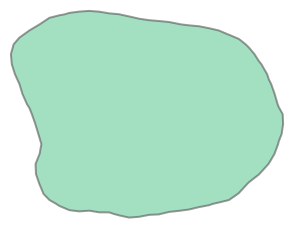

In [33]:
poly_image_crs

# Map for included/excluded islands

In [16]:
# Read file for islands to ignore
import shapely.geometry


df_islands_ignore = pd.read_excel('islands_to_ignore.xlsx')
list_islands_ignore = df_islands_ignore['Island'].values

path_to_data = os.path.join(os.getcwd(), 'data', 'info_islands')

print('Updating results maps...')

multi_point = []
multi_point_excluded = []

for file in tqdm(os.listdir(path_to_data)):
    island = file.split('_')[1] 
    country = file.split('_')[2].split('.')[0]

    try:
        island_info = retrieve_island_info(island, country, verbose=False)
        lat, lon = island_info['spatial_reference']['latitude'], island_info['spatial_reference']['longitude']
        point = shapely.geometry.Point(lon, lat)

        if island in list_islands_ignore:
            label = 'excluded'
            multi_point_excluded.append(point)

        else:
            label = 'included'
            multi_point.append(point)
    
    except:
        print('Error with island:', island)
        continue

mp = shapely.geometry.MultiPoint(multi_point)
mp_excluded = shapely.geometry.MultiPoint(multi_point_excluded)
gdf = gpd.GeoDataFrame(geometry=[mp], crs='EPSG:4326')
gdf_excluded = gpd.GeoDataFrame(geometry=[mp_excluded], crs='EPSG:4326')
gdf.to_file('shp//Huvadhoo_included.shp')
gdf_excluded.to_file('shp//Huvadhoo_excluded.shp')

Updating results maps...


  0%|          | 0/401 [00:00<?, ?it/s]

 86%|████████▋ | 346/401 [01:19<00:10,  5.46it/s]

Error with island: Qaruh Island


100%|██████████| 401/401 [01:29<00:00,  4.49it/s]
